# Lista de Exercícios \#4
## Breno Vieira Arosa

In [1]:
import numpy as np
from scipy import stats

from sklearn.datasets import make_blobs
from functools import partial

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

In [2]:
plt.rcParams.update({'font.size': 14})

## Questão 1

In [3]:
def matrix2float(x, x_range=4, bias=-2):
    """
    Transform binary matrix into float.
    Floats range and bias are defined by parameters.
    Floats are linearly separated.
    
    Axis 0 should have the length of the population size.
    Axis 1 should have the length of bit precision.
    """
    precision = x.shape[1]
    
    bit_multiplier = 2**np.linspace((precision-1), 0, precision)
    x_int = np.matmul(x, bit_multiplier)
    repr_eps = x_range / (2**precision)
    x = repr_eps * x_int
    x += bias
    return x


def J(x):
    return ((x**2) - (.3 * np.cos(10 * np.pi * x)))


def F(population):
    population = matrix2float(population)
    return -J(population)

In [4]:
np.random.seed = 7
x = np.random.randint(low=0, high=2,
                      size=(6, 8),
                      dtype="uint8")
print(f"Teste de funçao auxiliar:")
print(f"x como binario:\n{x}")
print(f"x como float:\n{matrix2float(x)}")

Teste de funçao auxiliar:
x como binario:
[[0 1 1 1 0 0 0 1]
 [0 0 0 1 0 0 1 0]
 [1 0 1 1 1 1 0 0]
 [0 0 1 0 1 1 0 1]
 [1 1 0 0 0 1 1 1]
 [0 0 0 0 1 0 0 1]]
x como float:
[-0.234375 -1.71875   0.9375   -1.296875  1.109375 -1.859375]


In [5]:
class SGA(object):
    
    def __init__(self, binary_size, population_size,
                 fitness_func, mutation_rate):
        self.binary_size = binary_size
        self.population_size = population_size
        self.fitness_func = fitness_func
        self.mutation_rate = mutation_rate
        
        self.population = self.init_population()
    
    
    def repr_str2matrix(self, population):
        """
        Represent population as a 2D matrix.
        """
        arr = np.zeros((len(population), self.binary_size)).astype("uint8")
        for i, x in enumerate(sga.population):
            arr[i, :] = np.array(list(x)).astype("uint8")
        return arr
    
    
    def repr_matrix2str(self, population):
        """
        Represent population as a vector of binary strings.
        """
        population = population.astype(int)
        matrix2str = lambda x: "".join(map(str, x))
        return np.apply_along_axis(matrix2str, axis=1, arr=population)
    
    
    def init_population(self):
        """
        Initialize binary vectors.
        """
        x0 = np.random.randint(low=0, high=2,
                               size=(self.population_size, self.binary_size),
                               dtype="uint8")
        return x0
    
    
    def evaluate(self, population):
        return self.fitness_func(population)
    
    
    def mutate(self, rate):
        """
        Bitwise Mutation.
        
        Mutate bits with given rate.
        """
        population = self.population.copy().astype(bool)
        mutation_rand = np.random.uniform(size=(self.population_size, self.binary_size))
        
        # invert bit if random sample < mutation rate
        population[mutation_rand < rate] = ~population[mutation_rand < rate]
        return population.astype("uint8")
    
    
    def recombine(self, parents):
        """
        One-Point Crossover.
        
        The formation of pairs are randomized.
        100% children are formed from recombination (crossover rate = 1).
        The point of crossover is randomized for each pair.
        Two children are created per pair of parents.
        """
        
        # shuffle parents before form pairs
        parents = parents.copy()
        np.random.shuffle(parents)
        
        # form pairs of parents
        parents = parents.reshape(-1, 2, self.binary_size)
                
        # defines the multiplier pattern to match crossover
        cross_multiplier = np.ones((parents.shape[0], 2, self.binary_size), dtype="uint8")
        for i in range(parents.shape[0]):
            # defines the point of crossover
            # there is no crossover if point equals 0 or (binary_size-1)
            cross_idx = np.random.randint(low=1, high=(self.binary_size - 2))
            cross_multiplier[i, 0, cross_idx:self.binary_size] = 0
            cross_multiplier[i, 1, 0:cross_idx] = 0
        
        # multipliers parent pairs by crossover pattern and anti-pattern
        # developing the same number of children as parents
        children_top = (parents * cross_multiplier).sum(axis=1)
        children_bot = (parents * (~cross_multiplier.astype(bool)).astype("uint8")).sum(axis=1)
        children = np.vstack((children_top, children_bot))
        
        return children

                             
    def parent_selection(self, s=1.5):
        """
        Generational model.
        Linear Ranking Selection with Roullete Wheel probabilities.
        """
        
        fitness = self.evaluate(self.population)
        rank = stats.rankdata(fitness, "ordinal")
        u = self.population_size     
        
        p = ((2 - s) / u) + ((2 * rank * (s-1)) / (u * (u - 1)))
        p = p / p.sum()
        
        select_idx = np.random.choice(np.linspace(0, (u-1), u),
                                      size=self.population_size,
                                      replace=True, p=p).astype(int)

        return self.population[select_idx, :]

    
    def natural_selection(self, parents, children, s=1.5):
        """
        Fitness-Based Replacement.
        Linear Ranking Selection with Roullete Wheel probabilities
        """
        population = np.concatenate((parents, children))
        
        fitness = self.evaluate(population)
        rank = stats.rankdata(fitness, "ordinal")
        u = len(population)   
        
        p = ((2 - s) / u) + ((2 * rank * (s-1)) / (u * (u - 1)))
        p = p / p.sum()
        
        select_idx = np.random.choice(np.linspace(0, (u-1), u),
                                      size=self.population_size,
                                      replace=True, p=p).astype(int)
        
        return population[select_idx, :]

    
    def evolve(self):
        parents = self.parent_selection(s=1.5)
        offspring = self.recombine(parents)
        offspring = self.mutate(self.mutation_rate)
        self.population = self.natural_selection(parents, offspring, s=1.5)
        return

In [6]:
sga = SGA(binary_size=64, population_size=100,
          fitness_func=F, mutation_rate=1/64)

In [7]:
N = 200

history = np.zeros((N, sga.population_size, sga.binary_size))
for i in range(N):
    history[i, :, :] = sga.population.copy()
    sga.evolve()

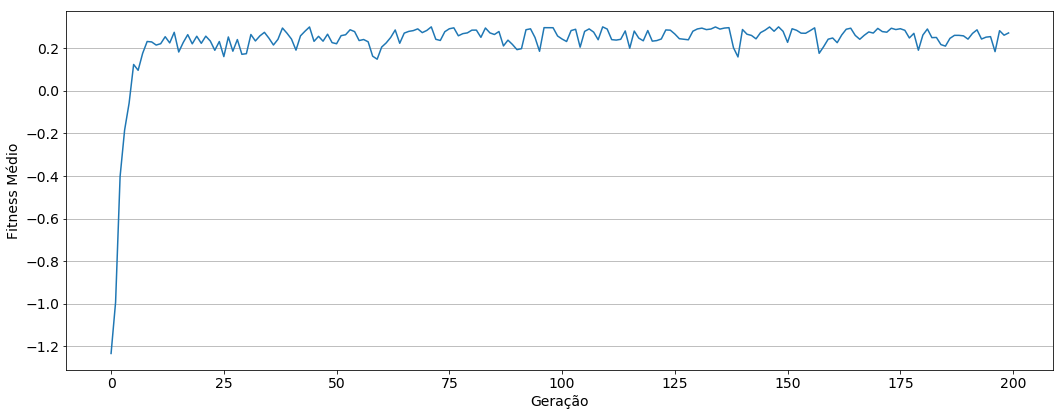

In [8]:
history_mean = np.zeros((N))
history_min = np.zeros((N))
history_max = np.zeros((N))
for i in range(N):
    fitness = sga.evaluate(history[i, :, :])
    fitness.std()
    history_mean[i] = fitness.mean()
    history_min[i] = fitness.min()
    history_max[i] = fitness.max()

plt.figure(figsize=(15, 6))

#plt.fill_between(np.linspace(0, N-1, N), history_min, history_max, alpha=.2)
plt.plot(np.linspace(0, N-1, N), history_mean)

plt.ylabel("Fitness Médio")
plt.xlabel("Geração")
plt.grid(axis="y")
plt.tight_layout()
plt.show()

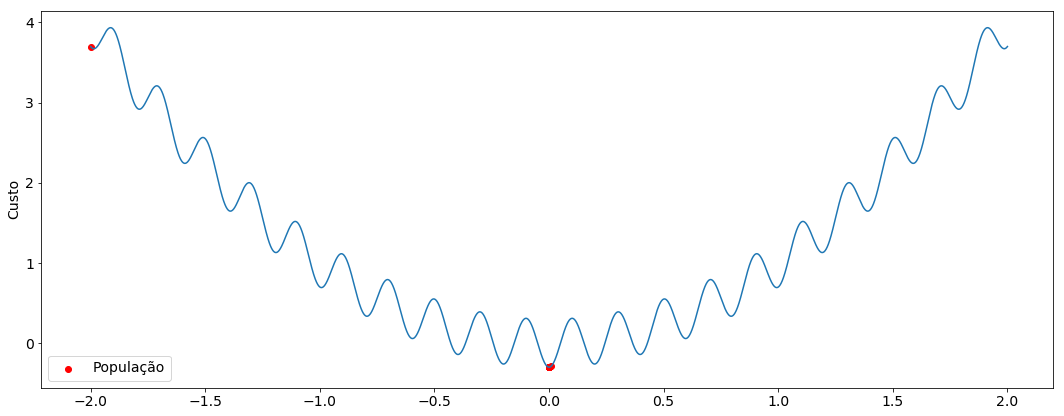

In [9]:
plt.figure(figsize=(15, 6))

population = matrix2float(sga.population)

x = np.linspace(-2, 2, 5000)
plt.plot(x, J(x))
plt.scatter(population, J(population), c="r", label="População")
plt.ylabel("Custo")
plt.legend()
plt.tight_layout()
plt.show()

## Questão 2

In [10]:
def onemax(populacao):
    return populacao.sum(axis=1)

In [16]:
# alterar parent selection
# alterar recombination (pc = .7)
# survival -> pure generational
sga = SGA(binary_size=25, population_size=100,
          fitness_func=onemax, mutation_rate=1/25)

In [17]:
N = 100

history = np.zeros((N, sga.population_size, sga.binary_size))
for i in range(N):
    history[i, :, :] = sga.population.copy()
    sga.evolve()

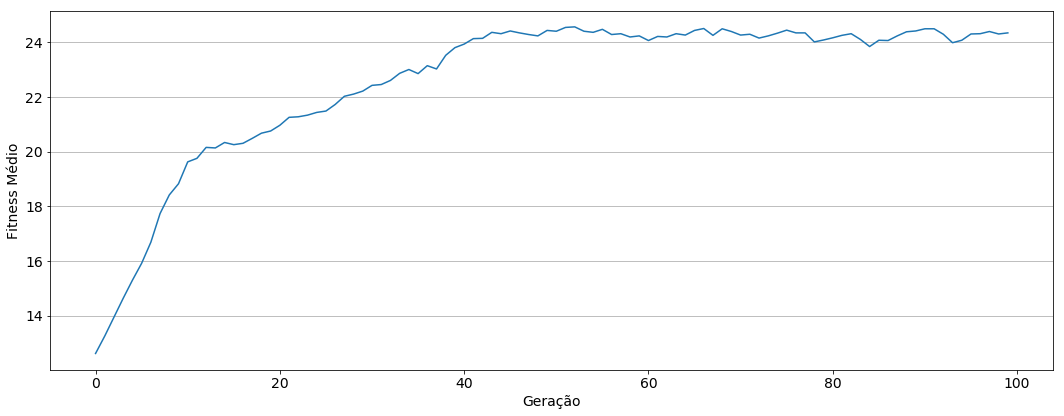

In [18]:
history_mean = np.zeros((N))
history_min = np.zeros((N))
history_max = np.zeros((N))
for i in range(N):
    fitness = sga.evaluate(history[i, :, :])
    fitness.std()
    history_mean[i] = fitness.mean()
    history_min[i] = fitness.min()
    history_max[i] = fitness.max()

plt.figure(figsize=(15, 6))

#plt.fill_between(np.linspace(0, N-1, N), history_min, history_max, alpha=.2)
plt.plot(np.linspace(0, N-1, N), history_mean)

plt.ylabel("Fitness Médio")
plt.xlabel("Geração")
plt.grid(axis="y")
plt.tight_layout()
plt.show()

In [20]:
sga.repr_matrix2str(sga.population)

array(['1111111111111111110111111', '1111111111111111111111111',
       '1111111110111111111111111', '0111111111111111111111101',
       '1111111111111111111111111', '1111111111111111111111111',
       '1111111111111111111111111', '1111110111111111011111111',
       '1111111011111111111111111', '1111101111111111111111111',
       '1111111111111111111111111', '1111111111111111111111111',
       '1111111111111111111111111', '1111111111111111110111111',
       '1111111111111111111111111', '1111111111111111111111111',
       '1111111111111111111111111', '1111111111111111111111111',
       '1011011111111111110111101', '1110111111111110111111111',
       '1111111111111111111111111', '1111101011111111111111111',
       '1111111111111111111111111', '1111111111111111111111111',
       '1111111111111111111111111', '1111111111111111111111111',
       '1111111111111011111111111', '1111111111111111111011111',
       '1111111111111011111111111', '1111111111111011111111111',
       '11111110111111111